In [54]:
%pylab inline

import logging as log
import fiona, shapely
from shapely.geometry import LineString, MultiPolygon
from shapely.ops import polygonize

import geopandas


mpl.rcParams['figure.figsize'] = [12, 10.0]


# vector layer with contacts
contacts = "../input_data/contacts" # contacts also contain the boundind box.


# here are a vector layer with points. each points need to have a field with an unique id for each geological unit
unit_id = "../input_data/unit_id"
unit_uuid_name = "unit_name" # the name of the field to use to populate the map.

# output data - geopackage
outputfname = "./output-map-data.gpkg"

dist = 1.0 # extend of 1 meters all the extreme segments of contacts - needed to ensure proper intersections

import os # we also use this example for generating images for the readme.
figdir = "../images/"
os.makedirs(figdir, exist_ok=True)

Populating the interactive namespace from numpy and matplotlib


In [55]:
cts= geopandas.GeoDataFrame.from_file(contacts)
units = geopandas.GeoDataFrame.from_file(unit_id)

In [56]:
cts = cts[cts.geometry.values != None] # remove null geometries

# plot the input dataset - contacts and points

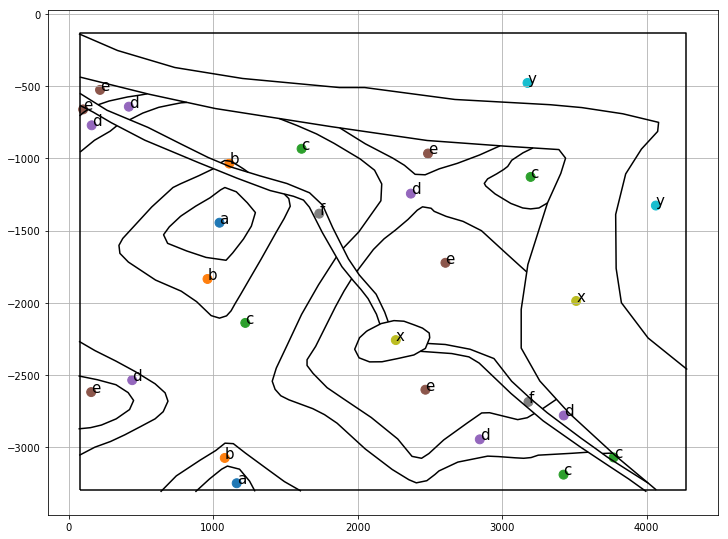

In [119]:
cts.plot(color="black", ax=gca())
units.plot( ax=gca(), edgecolor=None, column=unit_uuid_name, markersize=80)
savefig(os.path.join(figdir, "input_map.png"))

data = units[["geometry", unit_uuid_name]]

for id, row in data.iterrows():    
    text(row.geometry.x,row.geometry.y, row[unit_uuid_name], fontsize=15)

grid()
    
savefig(os.path.join(figdir, "input_map.png"))

<generator object DataFrame.iteritems at 0x7ff21031a4f8>

In [38]:


def extend(p1, p2, dist):
    """
    from p1 to p2 extended by dist.
    """
    v = p2 - p1
    v = v/np.linalg.norm(v) * dist
    
    news = p2 + v
    return news

out = [] # the collection of extended LineStrings
for f in cts.geometry:
    if f.is_closed is True:
        log.warning("shape is closed. skip - no need to extend it")
        l = LineString(np.row_stack([f.xy]).T)
        out.append(l)
        continue
        
    if not f.is_valid: # if the shape is no valid for some reason we remove it.
        log.warning("a not valid shape was found")
        continue
        
    
    pts = np.row_stack([f.xy]).T
    
    start = pts[:2][::-1]
    end = pts[::-1][:2][::-1]
    
    news = extend(start[0], start[1], dist)
    newe = extend(end[0], end[1], dist)

    extended = np.row_stack([news, pts, newe])
    
    
    l = LineString(extended)
    out.append(l)



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [39]:
# aa = cts.unary_union.intersection(cts.unary_union)
# aa.type

# Create a fast view of intersections so we can evaluate if the extension worked out fine

In [40]:
from geopandas import GeoDataFrame
cts.geoemtry = out

ints= []

for geom in cts.geometry:
    ii = cts.intersection(geom)
    for i in ii:
        if i.type == "MultiPoint":
            ints.extend(i)
        elif i.type == "Point":
            ints.append(i)
    
intersections = GeoDataFrame(geometry=ints)





# and plot 

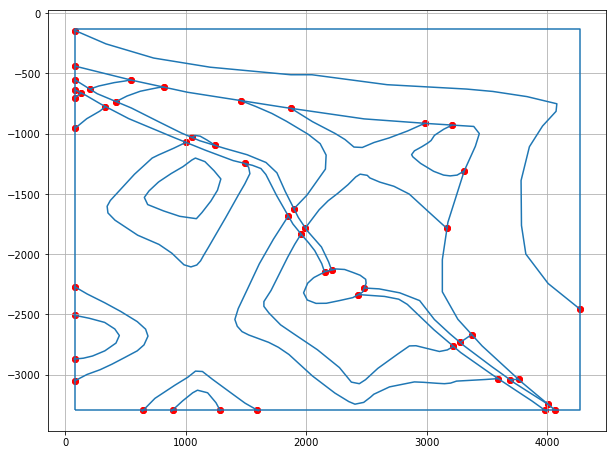

In [41]:
figure(figsize=(10,10))
intersections.plot(color="r", ax=gca())
cts.plot(ax=gca())
grid()

# and save the intersection in the output geopackage for external evaluation

In [42]:
intersections.to_file(outputfname , layer="intersections", driver="GPKG")

# now go ahead with polygonize

In [43]:
# first cascade unions
unified = shapely.ops.cascaded_union(cts.geometry)
pols = list( polygonize(unified) ) # first polygonize the features
polygons = GeoDataFrame(geometry =pols)

# do a plot

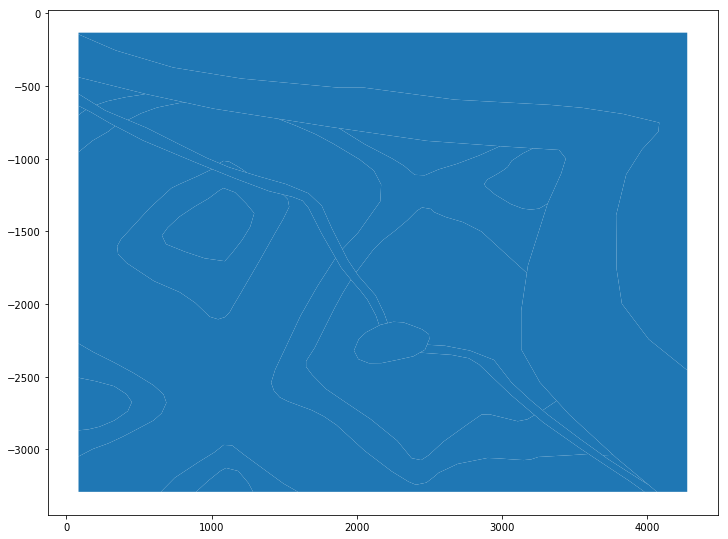

In [44]:
polygons.plot()

# and save to output geopackage

In [45]:
polygons.to_file(outputfname , layer="polygons", driver="GPKG")

# now we associate a point for each polygon
It is very likely that we could do this with a spatial join, but this gives us better control for performing checks on the consistency

In [46]:
def get_points_inside(polygon, points):
    """
    commodity function to get the ids of points falling within a polygon
    \note for now only Polygon is considered. - not MultiP
    """
    out = []
    for id, p in enumerate(points):
        if p.within(polygon):
            out.append(id)
            
    return out
            
        
outids = []
for pol in polygons.geometry:
    ids = get_points_inside(pol, units.geometry)
    log.info(f"found {len(ids)} ids: {ids}")
    thisunit = units[unit_uuid_name][ids].values
    log.info(f"thisunit {thisunit}")
    
    if len(ids) > 1:
        log.warning("more than two points were found in the same polygon")
    
        if np.all(thisunit == thisunit[0]):
            log.warning("no prob, because point to the same unit")
        
    if len(ids) < 1:
        log.error("cannot associate some polygons to an unit, missing points in unit definition file?")
        thisunit = [None]
    
    myunit = thisunit[0]
    outids.append(myunit)
    
    

# see result for some validation

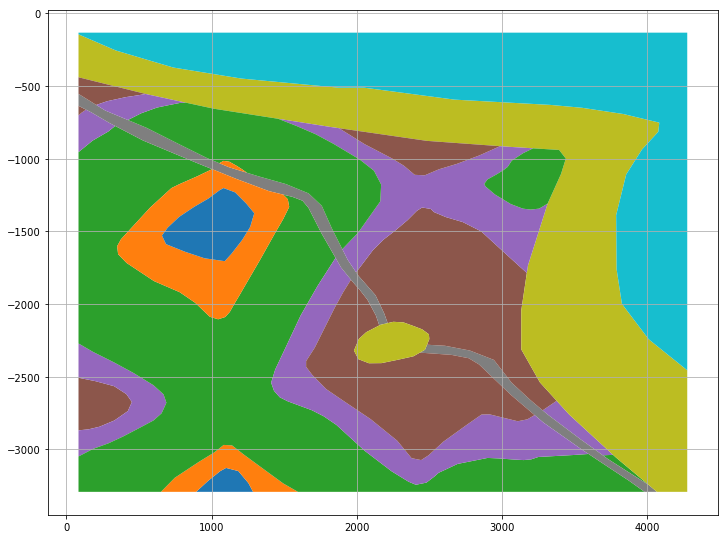

In [58]:
polygons[ unit_uuid_name] = outids
polygons.plot(column=unit_uuid_name)
grid()
savefig(os.path.join(figdir, "output_map.png"))

# save

In [48]:
polygons.to_file(outputfname , layer="polygons_labelled", driver="GPKG")